In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch as th
import csv

from cnn import CNN, createLossAndOptimizer
from torch.utils.data import DataLoader
from tqdm import tqdm

from imgdata import DefaultTrainSet

In [2]:
%matplotlib inline

if th.cuda.is_available():
  # Make CuDNN Determinist
  th.backends.cudnn.deterministic = True

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")
device

device(type='cpu')

### Set Constants
define learning rate as a list of values, and the number of epochs and batch size

In [3]:
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]
batch_size = 16
num_epochs = 20

### Load data
using the DefaultTrainSet class from imgdata.py

In [4]:
train_set = DefaultTrainSet()

train_dataloader = th.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [6]:
def train(net, batch, n_epochs, lr, train_loader):
    """
    Train a neural network and print statistics of the training

    :param train_loader: loader for the training data
    :param net: (PyTorch Neural Network)
    :param batch: (int)
    :param n_epochs: (int)  Number of iterations on the training set
    :param lr: (float) learning rate used by the optimizer
    """
    print("---------- HYPERPARAMETERS ----------")
    print("batch_size=", batch)
    print("n_epochs=", n_epochs)
    print("learning_rate=", lr)
    print("-" * 40)
    accuracies = []
    losses = []
    criterion, optimizer = createLossAndOptimizer(net, lr)
    # Move model to gpu if possible
    net = net.to(device)
    for epoch_count, epoch in enumerate(range(n_epochs)):
        # Set the model to training mode
        net.train()
        # Initialize the variables to compute the average loss
        total_loss = 0.00
        avg_loss = 0.00
        total_correct = 0
        pbar = tqdm(train_loader, leave=False)
        # Iterate over the training set
        for i, data in enumerate(pbar):

            # Get the inputs
            inputs, labels = data['imNorm'], data['label']
            # Move them to the correct device
            inputs = inputs.to(device)
            labels = labels.to(device)
            net = net.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = net(inputs)
             # Calculate Loss: softmax --> cross entropy loss
            loss = criterion(outputs, labels)
            
            _, preds = th.max(outputs, 1)

            # Getting gradients w.r.t. parameters
            loss.backward()

            # Updating parameters
            optimizer.step()

            # Update the running variables
            total_loss += loss.item()
            avg_loss = total_loss / (i + 1)
            total_correct += th.sum(preds == labels.data)
            pbar.set_description("Epoch: {}/{}".format(epoch_count + 1, n_epochs))
            pbar.set_postfix(avergae_loss=avg_loss, running_accuracy=th.sum(preds == labels).item() / float(labels.size(0)))
            # save the model
            model_name = f"models/model_{num_epochs}_epochs_learning_rate_{lr}.pth"
            th.save(net.state_dict(), model_name)

        # Calculate the average loss and accuracy of the epoch
        losses.append(total_loss/len(train_loader))
        accuracies.append((total_correct/train_loader.sampler.num_samples).item())
        # print losses and accuracies in the last epoch
        if epoch_count == n_epochs - 1:
            print("---------- FINAL RESULTS ----------")
            print("Losses fot every epoch:", losses)
            print("Average accuracy for each epoch: {}".format(accuracies))
            print("-" * 40)
    return losses, accuracies

In [17]:
cnn = CNN()
losses_list = []
accuracies_list = []
for learning_rate in learning_rates:
    print("Training with learning rate {}\n".format(learning_rate))
    loss, accu = train(cnn, batch_size, n_epochs=num_epochs, lr=learning_rate, train_loader=train_dataloader)
    losses_list.append(loss)
    accuracies_list.append(accu)
    print("-"*40)

Training with learning rate 0.01

---------- HYPERPARAMETERS ----------
batch_size= 16
n_epochs= 20
learning_rate= 0.01
----------------------------------------


---------- FINAL RESULTS ----------
Losses fot every epoch: [120.64590580896898, 23.695988687601957, 8.839428357102655, 3.872390751303597, 3.315979206072733, 2.6370037116144207, 1.842923170320723, 1.708429875365885, 1.1388127460749358, 1.5306319443030063, 0.9327578775070293, 0.6967288244799916, 0.3749381913628343, 0.5584224123713761, 0.7122720851753414, 0.5235382604666522, 0.5446050269553496, 0.031064544820035553, 0.11281412211982648, 0.7547901310607418]
Average accuracy for each epoch: [0.39714285731315613, 0.6885714530944824, 0.8057143092155457, 0.8628571629524231, 0.8971428275108337, 0.8885714411735535, 0.9285714030265808, 0.9028571248054504, 0.9371428489685059, 0.9314285516738892, 0.9485714435577393, 0.9628571271896362, 0.9714285731315613, 0.9685714244842529, 0.9599999785423279, 0.9571428298950195, 0.9714285731315613, 0.9942857027053833, 0.9828571677207947, 0.9657142758369446]
----------------------------------------
----------------------------------------
Training with learning r

---------- FINAL RESULTS ----------
Losses fot every epoch: [0.3797535168288368, 0.035785839009286405, 0.08775929019853121, 3.4677019680386745e-06, 0.026618211515545352, 0.0013253275563959671, 0.04257674068575625, 0.08004737972284687, 6.806633528124515e-07, 6.478977261922562e-05, 0.01139354819300007, 0.0915606263516515, 0.01419907131240787, 0.028361822580837828, 4.108650279538944e-05, 0.003734180724741763, 0.007296768642225373, 0.013463747788728497, 0.47457125877876005, 0.2088141911994752]
Average accuracy for each epoch: [0.9571428298950195, 0.991428554058075, 0.991428554058075, 1.0, 0.9942857027053833, 1.0, 0.9942857027053833, 0.991428554058075, 1.0, 1.0, 0.9971428513526917, 0.9942857027053833, 0.9971428513526917, 0.9942857027053833, 1.0, 0.9971428513526917, 0.9971428513526917, 0.9971428513526917, 0.9828571677207947, 0.9857142567634583]
----------------------------------------
----------------------------------------
Training with learning rate 0.0001

---------- HYPERPARAMETERS ----

---------- FINAL RESULTS ----------
Losses fot every epoch: [0.049468326751414576, 0.0008388105092797476, 0.0005661778427107053, 4.6043688431428684e-05, 4.151843545932818e-07, 1.4393057311646762e-07, 0.003960445228254026, 5.9265662902515975e-08, 2.4044972639232623e-08, 1.6933134288682988e-09, 3.697233027165726e-05, 0.0005410363939042373, 1.4788944429280158e-06, 0.00016292985831319179, 1.1820497182280965e-06, 8.584338909207129e-07, 0.013055739075928779, 5.587401692834377e-07, 3.3866273421975535e-10, 0.02158745953981618]
Average accuracy for each epoch: [0.9942857027053833, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9971428513526917, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9971428513526917, 1.0, 1.0, 0.9971428513526917]
----------------------------------------
----------------------------------------
Training with learning rate 1e-05

---------- HYPERPARAMETERS ----------
batch_size= 16
n_epochs= 20
learning_rate= 1e-05
----------------------------------------


---------- FINAL RESULTS ----------
Losses fot every epoch: [2.3706383119174875e-09, 0.00984035128546295, 3.3525642795240174e-07, 6.773254280677644e-10, 1.6004082267711601e-06, 2.370638715634951e-09, 1.964237893549058e-08, 3.197927972936105e-08, 0.00459265336388876, 1.6613342833144367e-06, 1.3546506946485433e-09, 0.00010034202918494309, 1.8185698861957048e-07, 8.441612325524065e-07, 3.6267593217913103e-06, 3.6336243682619984e-07, 3.3866256062124607e-09, 0.11542828651991725, 3.3866273421975535e-10, 1.1006342794737313e-07]
Average accuracy for each epoch: [1.0, 0.9971428513526917, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9971428513526917, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9971428513526917, 1.0, 1.0]
----------------------------------------
----------------------------------------


In [22]:
# plot the losses of training against the number of epochs
def plot_loss(losses, lr):
    plt.figure(figsize=(10,5))
    for _i, _loss in enumerate(losses):
        plt.plot(_loss, label="learning rate: {}".format(lr[_i]))
    plt.title("Loss vs. Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

# plot the accuracy of training against the number of epochs
def plot_accuracy(accuracies, lr):
    plt.figure(figsize=(10,5))
    for _i, _accu in enumerate(accuracies):
        plt.plot(_accu, label="learning rate: {}".format(lr[_i]))
    plt.title("Accuracy vs. Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.show()

In [31]:
# save the losses and accuracies in a numpy file
train_history = {'loss': np.array(losses_list), 'accuracy': np.array(accuracies_list)}
np.save('train_history.npy', train_history)

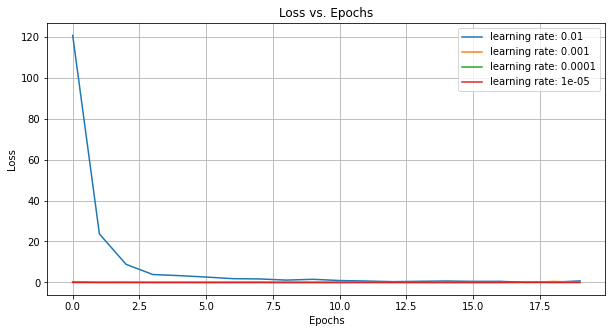

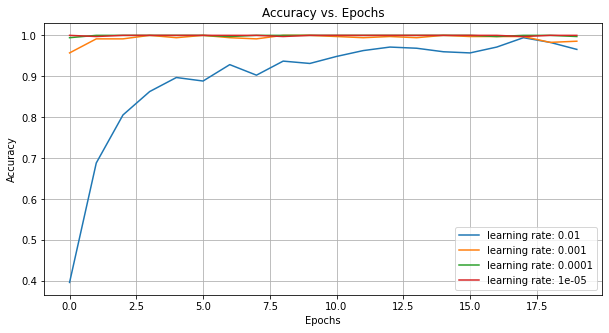

In [34]:
train_history = np.load('train_history.npy', allow_pickle=True).item()
losses = train_history['loss']
accuracies = train_history['accuracy']

#plot the losses and accuracies
plot_loss(losses, learning_rates)
plot_accuracy(accuracies, learning_rates)